In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
nat_gas = pd.read_csv('Nat_Gas.csv')

In [6]:
nat_gas.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


## Task 1

## Convert date column to datetime

In [7]:
nat_gas['Dates'] = pd.to_datetime(nat_gas['Dates'], dayfirst=True, errors='coerce')

/tmp/ipython-input-199201155.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nat_gas['Dates'] = pd.to_datetime(nat_gas['Dates'], dayfirst=True, errors='coerce')


In [8]:
df = nat_gas.copy()

In [9]:
df['Month'] = df['Dates'].dt.strftime('%B')
df.head()

,Dates,Prices,Month
0,2020-10-31,10.1,October
1,2020-11-30,10.3,November
2,2020-12-31,11.0,December
3,2021-01-31,10.9,January
4,2021-02-28,10.9,February


In [10]:
### Trend

In [11]:
ordered_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_trend = df.groupby('Month')['Prices'].mean().reindex(ordered_month)
monthly_trend.reset_index().round(2)

,Month,Prices
0,January,11.78
1,February,11.70
2,March,11.78
3,April,11.18
4,May,10.78
5,June,10.70
6,July,10.90
7,August,10.82
8,September,11.08
9,October,10.75


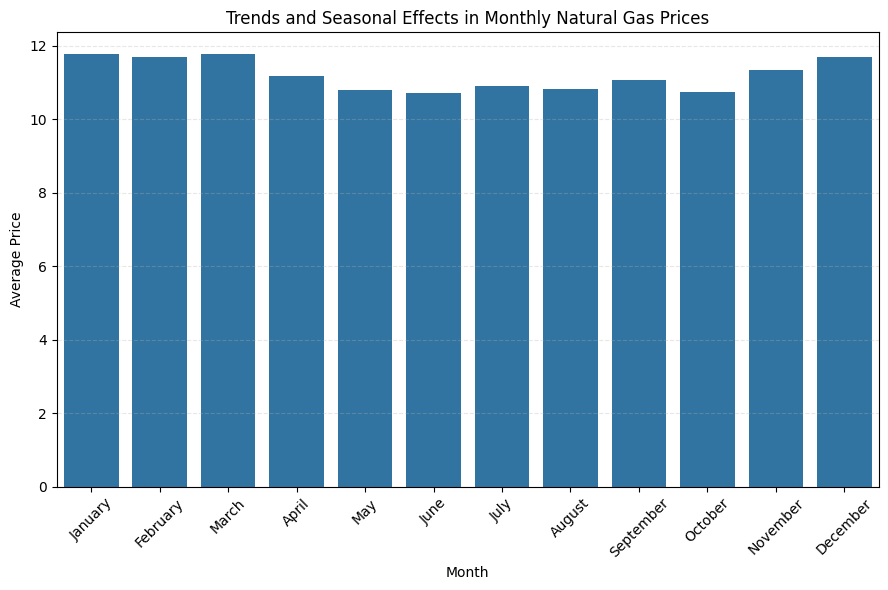

In [12]:
plt.figure(figsize=(9, 6))
sns.barplot(data=monthly_trend.reset_index(), x='Month', y='Prices')
plt.title('Trends and Seasonal Effects in Monthly Natural Gas Prices')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

<Axes: >

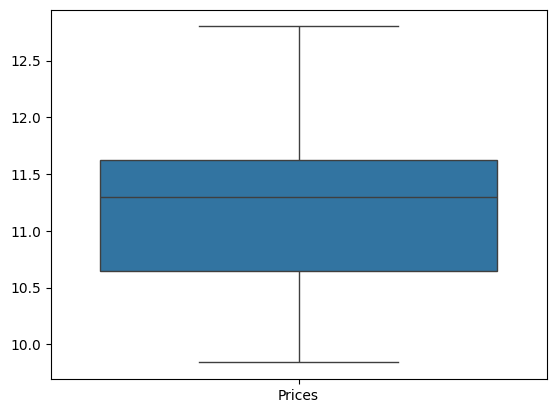

In [13]:
sns.boxplot(data=df)

In [22]:
data = df.iloc[:, [0,1]]

In [23]:
data.set_index('Dates', inplace=True)

### create days from 2020-10-31 to 2024-09-30

In [16]:
days = data.resample('D').mean()

### fill in missing daily prices to estimate gas orices using interpolation

In [24]:
days['Prices'] = days['Prices'].interpolate().round(2)

In [30]:
full_data = days.reset_index().rename(columns={'index': 'Dates'})
full_data.tail()

,Dates,Prices
1426,2024-09-26,11.76
1427,2024-09-27,11.77
1428,2024-09-28,11.78
1429,2024-09-29,11.79
1430,2024-09-30,11.80


In [35]:
# Ensure datetime index with daily frequency
if 'Dates' in full_data.columns:
    full_data['Dates'] = pd.to_datetime(full_data['Dates'])
    full_data = full_data.set_index('Dates')
else:
    # If Dates already the index, ensure datetime
    full_data.index = pd.to_datetime(full_data.index)

# Enforce daily frequency
full_data = full_data.asfreq('D')

# Interpolate missing prices if any
full_data['Prices'] = full_data['Prices'].interpolate()

In [37]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

series = full_data['Prices']

# Train Test Split
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Fit ARIMA on Train
arima_model = ARIMA(train, order=(2,1,2))
arima_results = arima_model.fit()

# Forecast on test set
arima_forecast = arima_results.forecast(steps=len(test))
rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))
mae_arima = mean_absolute_error(test, arima_forecast)
print(f"ARIMA RMSE: {rmse_arima:.4f}, MAE: {mae_arima:.4f}")




ARIMA RMSE: 0.9360, MAE: 0.7826


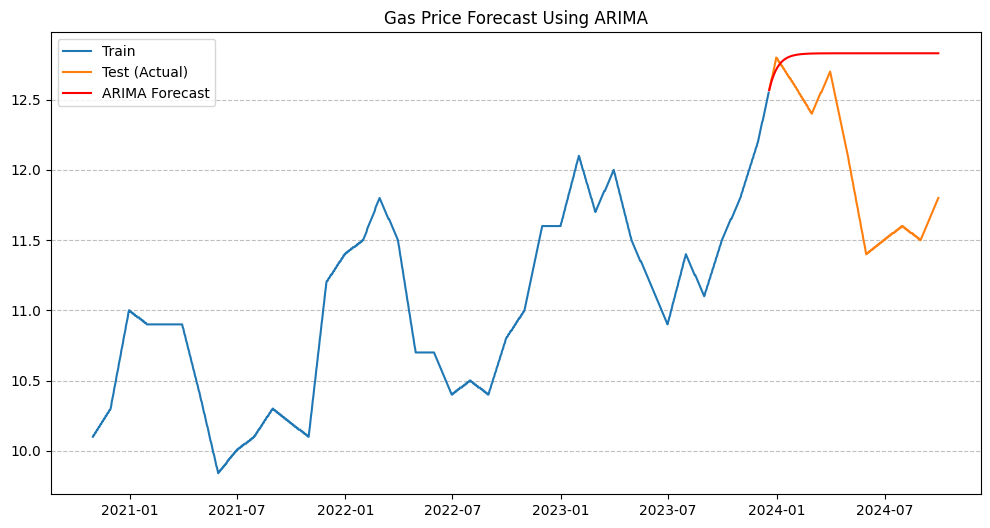

In [38]:
# ARIMA VISUALIZATION

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test (Actual)")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("Gas Price Forecast Using ARIMA")
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.savefig("ARIMA_forecast.png", dpi=300, bbox_inches='tight')
plt.show()



**function to estimate gas price for any date using ARIMA**

In [54]:
# Forecast + 1-year into the future
future_steps = 365
future_forecast = arima_results.forecast(steps=future_steps)
last_date = series.index[-1]
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Merge historical + forecast
arima_full_series = pd.concat([series, pd.Series(future_forecast.values, index=future_index)])

# Function
def estimate_price_arima(date):
    date = pd.to_datetime(date)
    arima_daily = arima_full_series.asfreq('D').interpolate()
    if date < arima_daily.index[0] or date > arima_daily.index[-1]:
        raise ValueError("Date is outside forecast bounds")
    return arima_daily.loc[date]

# Example Usage

print("ARIMA Estimated price on 2025-03-15:", estimate_price_arima('2025-03-15'))
print("ARIMA Estimated price on 2024-12-31:", estimate_price_arima('2024-12-31'))




ARIMA Estimated price on 2025-03-15: 12.830041188938267
ARIMA Estimated price on 2024-12-31: 12.829566935375606


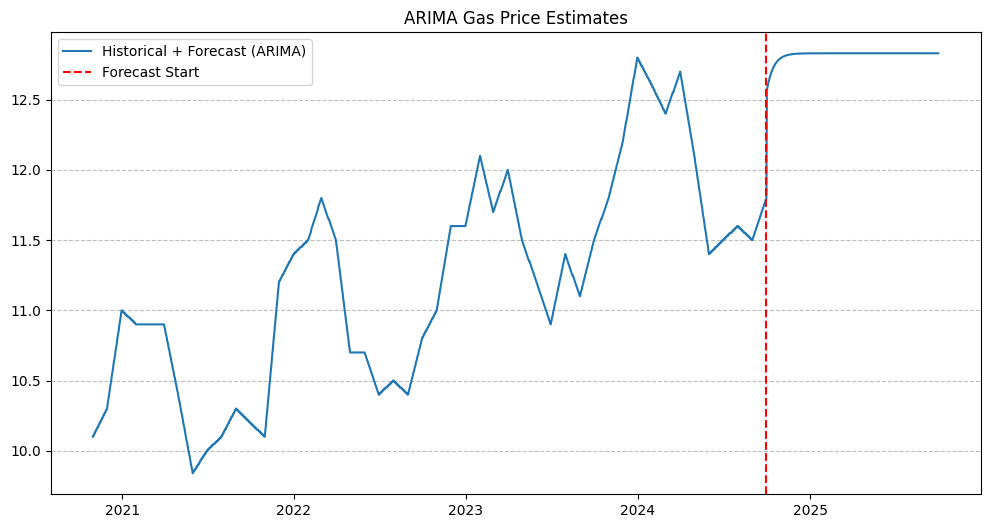

In [161]:
plt.figure(figsize=(12,6))
plt.plot(
    arima_full_series.index,
    arima_full_series,
    label="Historical + Forecast (ARIMA)"
)
plt.axvline(
    x=series.index[-1],
    color='red',
    linestyle='--',
    label='Forecast Start'
)
plt.legend()
plt.title("ARIMA Gas Price Estimates")
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.savefig("ARIMA_price_estimate.png", dpi=300, bbox_inches='tight')
plt.show()



In [57]:
# SARIMA MODEL (monthly seasonality = 12)

sarima_model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit()

# Forecast on test set
sarima_forecast = sarima_results.get_forecast(steps=len(test)).predicted_mean
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast))
mae_sarima = mean_absolute_error(test, sarima_forecast)
print(f"SARIMA RMSE: {rmse_sarima:.4f}, MAE: {mae_sarima:.4f}")



/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA RMSE: 1.6841, MAE: 1.4316


## Task 2

In [58]:
import pandas as pd
import datetime

In [159]:
def storage_contract(df_price,
                     injection_dates, withdrawal_dates,
                     injection_rate, withdrawal_rate,
                     max_volume, storage_cost,
                     return_breakdown=False):
    """
    df_price: DataFrame with 'Prices' and a datetime index (or a 'Dates' column).
    injection_dates, withdrawal_dates: list-like of dates (strings or Timestamps).
    injection_rate, withdrawal_rate: MMBtu/day.
    max_volume: max storage capacity (MMBtu).
    storage_cost: cost per MMBtu per day.
    return_breakdown: if True, also returns a dict of components.
    """

    # Normalize dataframe
    df = df_price.copy()
    if 'Dates' in df.columns:
        df['Dates'] = pd.to_datetime(df['Dates'])
        df = df.set_index('Dates')
    else:
        df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    if 'Prices' not in df.columns:
        raise ValueError("Input must contain a 'Prices' column.")

    # Map requested dates to available index (on-or-before)
    idx = df.index
    inj_dates = pd.to_datetime(pd.Index(injection_dates))
    wdr_dates = pd.to_datetime(pd.Index(withdrawal_dates))

    def map_pad(dates, index):
        pos = index.get_indexer(dates, method='pad')  # nearest <= date
        return set(index[p] for p in pos if p != -1)

    eff_inj = map_pad(inj_dates, idx)
    eff_wdr = map_pad(wdr_dates, idx)

    # Simulate daily flow
    volume = 0.0
    total_purchase = 0.0
    total_revenue = 0.0
    total_storage_fee = 0.0

    for date, price in df['Prices'].items():
        # inject first
        if date in eff_inj and volume < max_volume:
            injected = min(injection_rate, max_volume - volume)
            if injected > 0:
                volume += injected
                total_purchase += injected * float(price)

        # then withdraw
        if date in eff_wdr and volume > 0:
            withdrawn = min(withdrawal_rate, volume)
            if withdrawn > 0:
                volume -= withdrawn
                total_revenue += withdrawn * float(price)

        # end-of-day storage cost on remaining volume
        if volume > 0 and storage_cost:
            fee = volume * storage_cost
            total_storage_fee += fee

    net_value = total_revenue - total_purchase - total_storage_fee

    if return_breakdown:
        return net_value, {
            'total_revenue': total_revenue,
            'total_purchase': total_purchase,
            'storage_fee': total_storage_fee
        }
    return net_value

In [160]:
injection_dates = pd.to_datetime(['2024-06-01'])
withdrawal_dates = pd.to_datetime(['2024-12-01'])
injection_rate = 1
withdrawal_rate = 1
max_volume = 10
storage_cost = 0.001

net, parts = storage_contract(
    full_data,
    injection_dates, withdrawal_dates,
    injection_rate, withdrawal_rate,
    max_volume, storage_cost,
    return_breakdown=True
)

print(f"Net value: {net:.2f}")
print(parts)




Net value: 0.28
{'total_revenue': 11.8, 'total_purchase': 11.4, 'storage_fee': 0.1210000000000001}
